In [16]:
"""
Made on July 10th, 2019
@author: Theodore Pena
@contact: theodore.pena@tufts.edu
"""

line_color = 'green' # Color for the 10-panel plots
x_Delta = 3 # In our time units, the time between SDSS and HSC
default_Delta_value = -0.0843431604042636
data_path = '/home/tpena01/AGN_variability_project/Simulations/light_curves/v_bend_in_divided_10/results_v_bend_in_divided_10_{}.bin'

# Setup and imports

In [4]:
import sys
print("sys version: {}".format(sys.version))
# This project is entirely in python 3.7

import matplotlib
import matplotlib.pyplot as plt
%matplotlib qt 
# If you don't have an X server, line 7 might crash your kernel. Try '%matplotlib inline' instead.

import numpy as np
print("numpy version: {}".format(np.__version__))

from tqdm import tqdm
# This gives for loops progress bars.

import random
# This helps choosing random numbers from our arrays
random.seed() # Randomize seed

from IPython.core.display import display, HTML
# An alternate, cleaner take on the jupyter workspace
display(HTML("<style>.container { width:100% !important; }</style>"))

sys version: 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
numpy version: 1.16.2


In [5]:
%%javascript
try {
  require(['base/js/utils'], function (utils) {
    utils.load_extension('code_prettify/code_prettify');
    utils.load_extension('collapsible_headings/main'); 
    utils.load_extension('codefolding/edit'); 
    utils.load_extension('codefolding/main'); 
    utils.load_extension('execute_time/ExecuteTime');   
    utils.load_extension('toc2/main'); 
  });
}
catch (err) {
  console.log('toc2 load error:', err);
}

<IPython.core.display.Javascript object>

# Data extraction function

In [6]:
def extract_data(brightest_percent_lower=1, brightest_percent_upper=0, num_random_points=1000, t_max=10000, length_curve=2**24, num_curves=20):
    """
    Input: Parameters documented in the cell above
    Output: Graph of delta Eddington ratio as a function of delta time. 
    """
    
    if brightest_percent_lower <= brightest_percent_upper:
        sys.exit('Can\'t have an interval where the lower bound is greater than or equal to the upper bound. Remember, things are reversed. 100% is a reasonable lower bound, and brightest_percent_upper defaults to zero.')
        
        
    # Load the data
    default_curves = []
    for i in tqdm(range(num_curves + 1)):

        if i == 0:
            continue # for some reason the results files start at 1 and not 0

        _er_curve = np.zeros(length_curve, dtype=float)
        _er_curve = np.fromfile(data_path.format(str(i)))
        default_curves.append(_er_curve)

    default_curves = np.array(default_curves)

    default_curves = np.log10(default_curves) # Move everything into the log domain
    
    
    # Cut out the last t_max points
    cut_curves = np.zeros((np.array(list(default_curves.shape)) - np.array([0, t_max])))
    for i in tqdm(range(num_curves)):
        cut_curves[i, :] = default_curves[i, :-t_max]
    
    ##
    # Select all points brighter than brightest_percent_lower%
    num_brightest_lower = int(np.floor((cut_curves[0].shape[0] * (brightest_percent_lower/100))))
    
    if brightest_percent_lower == 100:
        num_brightest_lower = cut_curves[0].shape[0]
        
    if brightest_percent_lower == 0:
        sys.exit('Cannot use 0 as a lower bound.')
    
    else:
        indices_lower = []
        for i in tqdm(range(num_curves)):
            indices_lower.append(np.argpartition(cut_curves[i, :], -num_brightest_lower)[-num_brightest_lower:])

        indices_lower = np.array(indices_lower)
    
    
    # Select all points brighter than brightest_percent_upper%
    num_brightest_upper = int(np.floor((cut_curves[0].shape[0] * (brightest_percent_upper/100))))
    
    
    if brightest_percent_upper == 100:
        num_brightest_upper = cut_curves[0].shape[0]
        
    if brightest_percent_upper == 0:
        indices_upper = []
        for i in range(num_curves):
            indices_upper.append(np.array([]))
    
    else:
        indices_upper = []
        for i in tqdm(range(num_curves)):
            indices_upper.append(np.argpartition(cut_curves[i, :], -num_brightest_upper)[-num_brightest_upper:])

        indices_upper = np.array(indices_upper)
    
    
    indices = []
    for i in range(num_curves):
        indices.append(np.setdiff1d(indices_lower[i], indices_upper[i], assume_unique=True))
    
    ##
    
    # Randomly sample from the chosen indices
    chosen_indices = []
    for brightest_points_in_curve in tqdm(indices):
        chosen_indices.append(random.sample(list(brightest_points_in_curve), num_random_points))

    chosen_indices = np.array(chosen_indices, dtype=int)
    
    
    # Find the smallest number that we've chosen (We print this out later)
    small_points = []
    for i in tqdm(range(num_curves)):
        small_points.append(np.min(cut_curves[i][chosen_indices[i]]))

    smallest_point = "Min log(Edd): " + str(np.min(small_points))[:6]
    
    
    # Select all our points
    t_examine = np.logspace(0, np.log10(t_max), np.log(t_max)*10 + 1).astype(int)
    t_log = np.log10(t_examine) # Used later

    t_array = np.tile(t_examine, (num_random_points, 1))

    master_array = np.zeros(t_examine.shape, dtype=int)

    for i in tqdm(range(num_curves)):
        indices_array = np.tile(chosen_indices[i, :], (t_array.shape[1], 1)).T

        indices_array = indices_array + t_array    
        master_array = np.vstack((default_curves[i][indices_array], master_array))

    master_array = np.delete(master_array, -1, 0)

    starting_vals = np.copy(master_array[:, 0])
    for i in tqdm(range(master_array.shape[1])):
        master_array[:, i] = master_array[:, i] - starting_vals
        

    # Find our trends
    means = []
    stands = []

    for i in tqdm(range(master_array.shape[1])):
        means.append(np.mean(master_array[:, i]))
        stands.append(np.std(master_array[:, i]))

    means = np.array(means)
    stands = np.array(stands)
    
    
    # Get a line of best fit
    best_fit = np.poly1d(np.poly1d(np.polyfit(t_log.astype(float)[1:], means.astype(float)[1:], 1)))
    
    return (t_log, means, stands, best_fit, smallest_point)

# Main

In [7]:
t_log100, means100, stands100, best_fit100, smallest_point100 = extract_data(brightest_percent_lower=100, brightest_percent_upper=50)

t_log50, means50, stands50, best_fit50, smallest_point50 = extract_data(brightest_percent_lower=50, brightest_percent_upper=10)

t_log10, means10, stands10, best_fit10, smallest_point10 = extract_data(brightest_percent_lower=10, brightest_percent_upper=5)

t_log5, means5, stands5, best_fit5, smallest_point5 = extract_data(brightest_percent_lower=5, brightest_percent_upper=1)

t_log1, means1, stands1, best_fit1, smallest_point1 = extract_data(brightest_percent_lower=1, brightest_percent_upper=0.5)

t_log05, means05, stands05, best_fit05, smallest_point05 = extract_data(brightest_percent_lower=0.5, brightest_percent_upper=0.1)

t_log01, means01, stands01, best_fit01, smallest_point01 = extract_data(brightest_percent_lower=0.1, brightest_percent_upper=0.05)

t_log005, means005, stands005, best_fit005, smallest_point005 = extract_data(brightest_percent_lower=0.05, brightest_percent_upper=0.02)

t_log002, means002, stands002, best_fit002, smallest_point002 = extract_data(brightest_percent_lower=0.02, brightest_percent_upper=0.006)

t_loginf, meansinf, standsinf, best_fitinf, smallest_pointinf = extract_data(brightest_percent_lower=0.006)

100%|██████████| 93/93 [00:00<00:00, 1366.00it/s]


In [12]:
log_t_1 = [means100[np.where(t_log100==1)[0][0]], means50[np.where(t_log50==1)[0][0]], means10[np.where(t_log10==1)[0][0]], means5[np.where(t_log5==1)[0][0]], means1[np.where(t_log1==1)[0][0]], means05[np.where(t_log05==1)[0][0]], means01[np.where(t_log01==1)[0][0]], means005[np.where(t_log005==1)[0][0]], means002[np.where(t_log002==1)[0][0]], meansinf[np.where(t_loginf==1)[0][0]]]
log_t_2 = [means100[np.where(t_log100==2)[0][0]], means50[np.where(t_log50==2)[0][0]], means10[np.where(t_log10==2)[0][0]], means5[np.where(t_log5==2)[0][0]], means1[np.where(t_log1==2)[0][0]], means05[np.where(t_log05==2)[0][0]], means01[np.where(t_log01==2)[0][0]], means005[np.where(t_log005==2)[0][0]], means002[np.where(t_log002==2)[0][0]], meansinf[np.where(t_loginf==2)[0][0]]]
log_t_3 = [means100[np.where(t_log100==3)[0][0]], means50[np.where(t_log50==3)[0][0]], means10[np.where(t_log10==3)[0][0]], means5[np.where(t_log5==3)[0][0]], means1[np.where(t_log1==3)[0][0]], means05[np.where(t_log05==3)[0][0]], means01[np.where(t_log01==3)[0][0]], means005[np.where(t_log005==3)[0][0]], means002[np.where(t_log002==3)[0][0]], meansinf[np.where(t_loginf==3)[0][0]]]
log_t_4 = [means100[np.where(t_log100==4)[0][0]], means50[np.where(t_log50==4)[0][0]], means10[np.where(t_log10==4)[0][0]], means5[np.where(t_log5==4)[0][0]], means1[np.where(t_log1==4)[0][0]], means05[np.where(t_log05==4)[0][0]], means01[np.where(t_log01==4)[0][0]], means005[np.where(t_log005==4)[0][0]], means002[np.where(t_log002==4)[0][0]], meansinf[np.where(t_loginf==4)[0][0]]]

log_t_1_stands = np.log10(np.array([stands100[np.where(t_log100==1)[0][0]], stands50[np.where(t_log50==1)[0][0]], stands10[np.where(t_log10==1)[0][0]], stands5[np.where(t_log5==1)[0][0]], stands1[np.where(t_log1==1)[0][0]], stands05[np.where(t_log05==1)[0][0]], stands01[np.where(t_log01==1)[0][0]], stands005[np.where(t_log005==1)[0][0]], stands002[np.where(t_log002==1)[0][0]], standsinf[np.where(t_loginf==1)[0][0]]]))
log_t_2_stands = np.log10(np.array([stands100[np.where(t_log100==2)[0][0]], stands50[np.where(t_log50==2)[0][0]], stands10[np.where(t_log10==2)[0][0]], stands5[np.where(t_log5==2)[0][0]], stands1[np.where(t_log1==2)[0][0]], stands05[np.where(t_log05==2)[0][0]], stands01[np.where(t_log01==2)[0][0]], stands005[np.where(t_log005==2)[0][0]], stands002[np.where(t_log002==2)[0][0]], standsinf[np.where(t_loginf==2)[0][0]]]))
log_t_3_stands = np.log10(np.array([stands100[np.where(t_log100==3)[0][0]], stands50[np.where(t_log50==3)[0][0]], stands10[np.where(t_log10==3)[0][0]], stands5[np.where(t_log5==3)[0][0]], stands1[np.where(t_log1==3)[0][0]], stands05[np.where(t_log05==3)[0][0]], stands01[np.where(t_log01==3)[0][0]], stands005[np.where(t_log005==3)[0][0]], stands002[np.where(t_log002==3)[0][0]], standsinf[np.where(t_loginf==3)[0][0]]]))
log_t_4_stands = np.log10(np.array([stands100[np.where(t_log100==4)[0][0]], stands50[np.where(t_log50==4)[0][0]], stands10[np.where(t_log10==4)[0][0]], stands5[np.where(t_log5==4)[0][0]], stands1[np.where(t_log1==4)[0][0]], stands05[np.where(t_log05==4)[0][0]], stands01[np.where(t_log01==4)[0][0]], stands005[np.where(t_log005==4)[0][0]], stands002[np.where(t_log002==4)[0][0]], standsinf[np.where(t_loginf==4)[0][0]]]))

x = np.log10(np.array([100, 50, 10, 5, 1, 0.5, 0.1, 0.05, 0.02, 0.006]))

# Delta value

In [9]:
Delta_value = means05[np.where(t_log05==x_Delta)][0]
print('For this set of parameters, Delta is ' + str(Delta_value - default_Delta_value) + '.')
print('Remember, a negative delta (approximately) means that the curve was steeper than the default plot of log Edd. Ratio as a function of time.')

For this set of parameters, Delta is 0.0749519336922894.
Remember, a negative delta (approximately) means that the curve was steeper than the default plot of log Edd. Ratio as a function of time.


# Graphs

## 10-panel plots

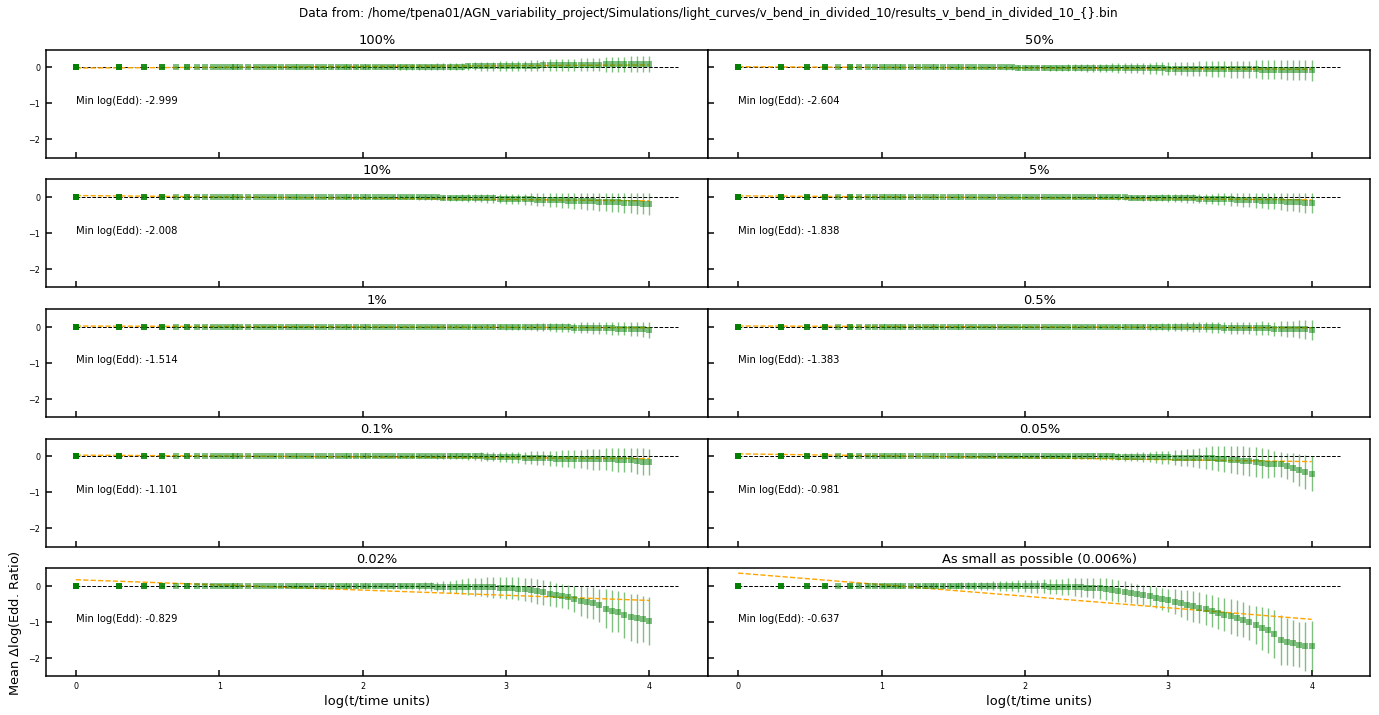

In [17]:
# Delta Eddington ratio plots
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(5, 2, figsize=(20, 10), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1], 'wspace':0, 'left':0.04, 'right':0.96, 'bottom':0.05, 'top':0.92})
    fig.suptitle('Data from: ' + data_path)
    ax[0,0].set_title('100%', fontsize=13)
    ax[0,0].tick_params(direction='in', length=6, width=1.5)
    ax[0,0].spines['top'].set_linewidth(1.5)
    ax[0,0].spines['right'].set_linewidth(1.5)
    ax[0,0].spines['bottom'].set_linewidth(1.5)
    ax[0,0].spines['left'].set_linewidth(1.5)
    
    ax[0,0].hlines(0, 0, t_log100[-1] + 0.2, linewidth=1, linestyle='--')
    ax[0,0].errorbar(t_log100, means100, yerr=stands100, fmt='s', alpha=0.5, color=line_color)
    ax[0,0].plot(t_log100[1:], best_fit100(t_log100[1:].astype(float)), ls='--', color='orange')
    
    ax[0,0].text(0, -1, smallest_point100)
    
    
    
    ax[0,1].set_title('50%', fontsize=13)
    ax[0,1].tick_params(direction='in', length=6, width=1.5)
    ax[0,1].spines['top'].set_linewidth(1.5)
    ax[0,1].spines['right'].set_linewidth(1.5)
    ax[0,1].spines['bottom'].set_linewidth(1.5)
    ax[0,1].spines['left'].set_linewidth(1.5)
    
    ax[0,1].hlines(0, 0, t_log50[-1] +0.2, linewidth=1, linestyle='--')
    ax[0,1].errorbar(t_log50, means50, yerr=stands50, fmt='s', alpha=0.5, color=line_color)
    ax[0,1].plot(t_log50[1:], best_fit50(t_log50[1:].astype(float)), ls='--', color='orange')
    
    ax[0,1].text(0, -1, smallest_point50)
    
    
    
    ax[1,0].set_title('10%', fontsize=13)
    ax[1,0].tick_params(direction='in', length=6, width=1.5)
    ax[1,0].spines['top'].set_linewidth(1.5)
    ax[1,0].spines['right'].set_linewidth(1.5)
    ax[1,0].spines['bottom'].set_linewidth(1.5)
    ax[1,0].spines['left'].set_linewidth(1.5)
    
    ax[1,0].hlines(0, 0, t_log10[-1] +0.2, linewidth=1, linestyle='--')
    ax[1,0].errorbar(t_log10, means10, yerr=stands10, fmt='s', alpha=0.5, color=line_color)
    ax[1,0].plot(t_log10[1:], best_fit10(t_log10[1:].astype(float)), ls='--', color='orange')
    
    ax[1,0].text(0, -1, smallest_point10)
    
    
    
    ax[1,1].set_title('5%', fontsize=13)
    ax[1,1].tick_params(direction='in', length=6, width=1.5)
    ax[1,1].spines['top'].set_linewidth(1.5)
    ax[1,1].spines['right'].set_linewidth(1.5)
    ax[1,1].spines['bottom'].set_linewidth(1.5)
    ax[1,1].spines['left'].set_linewidth(1.5)
    
    ax[1,1].hlines(0,  0, t_log5[-1] +0.2, linewidth=1, linestyle='--')
    ax[1,1].errorbar(t_log5, means5, yerr=stands5, fmt='s', alpha=0.5, color=line_color)
    ax[1,1].plot(t_log5[1:], best_fit5(t_log5[1:].astype(float)), ls='--', color='orange')
    
    ax[1,1].text(0, -1, smallest_point5)
    
    
    
    ax[2,0].set_title('1%', fontsize=13)
    ax[2,0].tick_params(direction='in', length=6, width=1.5)
    ax[2,0].spines['top'].set_linewidth(1.5)
    ax[2,0].spines['right'].set_linewidth(1.5)
    ax[2,0].spines['bottom'].set_linewidth(1.5)
    ax[2,0].spines['left'].set_linewidth(1.5)
    
    ax[2,0].hlines(0, 0, t_log1[-1] +0.2, linewidth=1, linestyle='--')
    ax[2,0].errorbar(t_log1, means1, yerr=stands1, fmt='s', alpha=0.5, color=line_color)
    ax[2,0].plot(t_log1[1:], best_fit1(t_log1[1:].astype(float)), ls='--', color='orange')
    
    ax[2,0].text(0, -1, smallest_point1)
    

    
    
    ax[2,1].set_title('0.5%', fontsize=13)
    ax[2,1].tick_params(direction='in', length=6, width=1.5)
    ax[2,1].spines['top'].set_linewidth(1.5)
    ax[2,1].spines['right'].set_linewidth(1.5)
    ax[2,1].spines['bottom'].set_linewidth(1.5)
    ax[2,1].spines['left'].set_linewidth(1.5)
    
    ax[2,1].hlines(0, 0, t_log05[-1] +0.2, linewidth=1, linestyle='--')
    ax[2,1].errorbar(t_log05, means05, yerr=stands05, fmt='s', alpha=0.5, color=line_color)
    ax[2,1].plot(t_log05[1:], best_fit05(t_log05[1:].astype(float)), ls='--', color='orange')
    
    ax[2,1].text(0, -1, smallest_point05)
    
    
    ax[3,0].set_title('0.1%', fontsize=13)
    ax[3,0].tick_params(direction='in', length=6, width=1.5)
    ax[3,0].spines['top'].set_linewidth(1.5)
    ax[3,0].spines['right'].set_linewidth(1.5)
    ax[3,0].spines['bottom'].set_linewidth(1.5)
    ax[3,0].spines['left'].set_linewidth(1.5)
    
    ax[3,0].hlines(0, 0, t_log01[-1] +0.2, linewidth=1, linestyle='--')
    ax[3,0].errorbar(t_log01, means01, yerr=stands01, fmt='s', alpha=0.5, color=line_color)
    ax[3,0].plot(t_log01[1:], best_fit01(t_log01[1:].astype(float)), ls='--', color='orange')
    
    ax[3,0].text(0, -1, smallest_point01)
    

    
    
    ax[3,1].set_title('0.05%', fontsize=13)
    ax[3,1].tick_params(direction='in', length=6, width=1.5)
    ax[3,1].spines['top'].set_linewidth(1.5)
    ax[3,1].spines['right'].set_linewidth(1.5)
    ax[3,1].spines['bottom'].set_linewidth(1.5)
    ax[3,1].spines['left'].set_linewidth(1.5)
    
    ax[3,1].hlines(0, 0, t_log005[-1] +0.2, linewidth=1, linestyle='--')
    ax[3,1].errorbar(t_log005, means005, yerr=stands005, fmt='s', alpha=0.5, color=line_color)
    ax[3,1].plot(t_log005[1:], best_fit005(t_log005[1:].astype(float)), ls='--', color='orange')
    
    ax[3,1].text(0, -1, smallest_point005)
    
    
    
    ax[4,0].set_title('0.02%', fontsize=13)
    ax[4,0].tick_params(direction='in', length=6, width=1.5)
    ax[4,0].spines['top'].set_linewidth(1.5)
    ax[4,0].spines['right'].set_linewidth(1.5)
    ax[4,0].spines['bottom'].set_linewidth(1.5)
    ax[4,0].spines['left'].set_linewidth(1.5)
    ax[4,0].set_xlabel('log(t/time units)', fontsize=13)
    ax[4,0].set_ylabel('Mean $\Delta$log(Edd. Ratio)', fontsize=13)
    
    ax[4,0].hlines(0, 0, t_log002[-1] +0.2, linewidth=1, linestyle='--')
    ax[4,0].errorbar(t_log002, means002, yerr=stands002, fmt='s', alpha=0.5, color=line_color)
    ax[4,0].plot(t_log002[1:], best_fit002(t_log002[1:].astype(float)), ls='--', color='orange')
    
    ax[4,0].text(0, -1, smallest_point002)
    
    
    
    ax[4,1].set_title('As small as possible (0.006%)', fontsize=13)
    ax[4,1].tick_params(direction='in', length=6, width=1.5)
    ax[4,1].spines['top'].set_linewidth(1.5)
    ax[4,1].spines['right'].set_linewidth(1.5)
    ax[4,1].spines['bottom'].set_linewidth(1.5)
    ax[4,1].spines['left'].set_linewidth(1.5)
    ax[4,1].set_xlabel('log(t/time units)', fontsize=13)
    
    ax[4,1].hlines(0, 0, t_loginf[-1] +0.2, linewidth=1, linestyle='--')
    ax[4,1].errorbar(t_loginf, meansinf, yerr=standsinf, fmt='s', alpha=0.5, color=line_color)
    ax[4,1].plot(t_loginf[1:], best_fitinf(t_loginf[1:].astype(float)), ls='--', color='orange')
    
    ax[4,1].text(0, -1, smallest_pointinf)
    
plt.savefig('10-panel_eddington_plot.pdf', bbox_inches='tight')  
plt.show()

/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log10
  
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:42: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:56: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:70: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:98: RuntimeWarning: divide by zero encountered in log10
/home/tpena01/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:113: RuntimeW

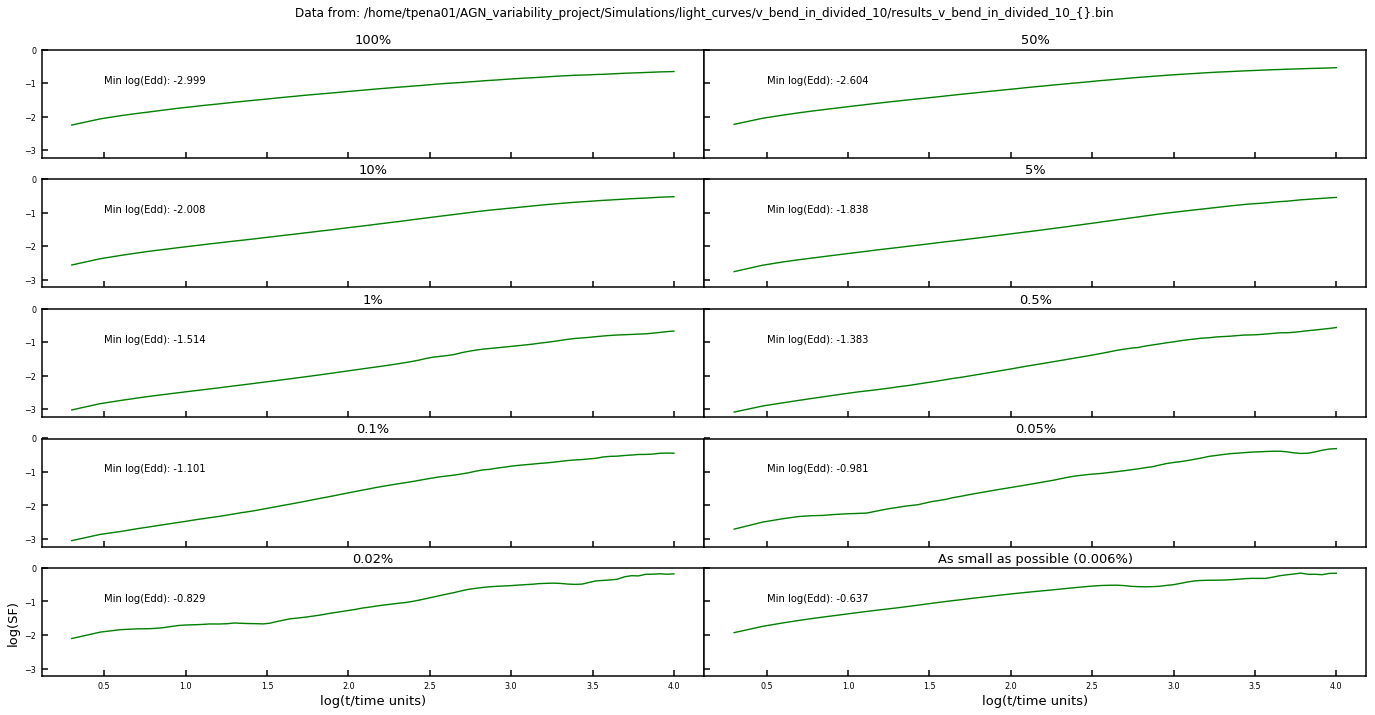

In [18]:
# Structure function plots
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(5, 2, figsize=(20, 10), sharex=True, sharey=True, gridspec_kw={'width_ratios': [1, 1], 'wspace':0, 'left':0.04, 'right':0.96, 'bottom':0.05, 'top':0.92})
    fig.suptitle('Data from: ' + data_path)
    
    ax[0,0].set_title('100%', fontsize=13)
    ax[0,0].tick_params(direction='in', length=6, width=1.5)
    ax[0,0].spines['top'].set_linewidth(1.5)
    ax[0,0].spines['right'].set_linewidth(1.5)
    ax[0,0].spines['bottom'].set_linewidth(1.5)
    ax[0,0].spines['left'].set_linewidth(1.5)
    
    
    ax[0,0].plot(t_log100[1:], np.log10(stands100[1:]), color=line_color)
    
    ax[0,0].text(0.5, -1, smallest_point100)
    
    
    
    ax[0,1].set_title('50%', fontsize=13)
    ax[0,1].tick_params(direction='in', length=6, width=1.5)
    ax[0,1].spines['top'].set_linewidth(1.5)
    ax[0,1].spines['right'].set_linewidth(1.5)
    ax[0,1].spines['bottom'].set_linewidth(1.5)
    ax[0,1].spines['left'].set_linewidth(1.5)
    
    
    ax[0,1].plot(t_log50[1:], np.log10(stands50[1:]), color=line_color)
    
    ax[0,1].text(0.5, -1, smallest_point50)
    
    
    
    ax[1,0].set_title('10%', fontsize=13)
    ax[1,0].tick_params(direction='in', length=6, width=1.5)
    ax[1,0].spines['top'].set_linewidth(1.5)
    ax[1,0].spines['right'].set_linewidth(1.5)
    ax[1,0].spines['bottom'].set_linewidth(1.5)
    ax[1,0].spines['left'].set_linewidth(1.5)
    
    
    ax[1,0].plot(t_log10[1:], np.log10(stands10[1:]), color=line_color)
    
    ax[1,0].text(0.5, -1, smallest_point10)
    
    
    
    ax[1,1].set_title('5%', fontsize=13)
    ax[1,1].tick_params(direction='in', length=6, width=1.5)
    ax[1,1].spines['top'].set_linewidth(1.5)
    ax[1,1].spines['right'].set_linewidth(1.5)
    ax[1,1].spines['bottom'].set_linewidth(1.5)
    ax[1,1].spines['left'].set_linewidth(1.5)
    
    
    ax[1,1].plot(t_log5[1:], np.log10(stands5[1:]), color=line_color)
    
    ax[1,1].text(0.5, -1, smallest_point5)
    
    
    
    ax[2,0].set_title('1%', fontsize=13)
    ax[2,0].tick_params(direction='in', length=6, width=1.5)
    ax[2,0].spines['top'].set_linewidth(1.5)
    ax[2,0].spines['right'].set_linewidth(1.5)
    ax[2,0].spines['bottom'].set_linewidth(1.5)
    ax[2,0].spines['left'].set_linewidth(1.5)
    
    
    ax[2,0].plot(t_log1[1:], np.log10(stands1[1:]), color=line_color)
    
    ax[2,0].text(0.5, -1, smallest_point1)
    

    
    
    ax[2,1].set_title('0.5%', fontsize=13)
    ax[2,1].tick_params(direction='in', length=6, width=1.5)
    ax[2,1].spines['top'].set_linewidth(1.5)
    ax[2,1].spines['right'].set_linewidth(1.5)
    ax[2,1].spines['bottom'].set_linewidth(1.5)
    ax[2,1].spines['left'].set_linewidth(1.5)
    
    
    ax[2,1].plot(t_log05[1:], np.log10(stands05[1:]), color=line_color)
    
    ax[2,1].text(0.5, -1, smallest_point05)
    
    
    ax[3,0].set_title('0.1%', fontsize=13)
    ax[3,0].tick_params(direction='in', length=6, width=1.5)
    ax[3,0].spines['top'].set_linewidth(1.5)
    ax[3,0].spines['right'].set_linewidth(1.5)
    ax[3,0].spines['bottom'].set_linewidth(1.5)
    ax[3,0].spines['left'].set_linewidth(1.5)
    
    
    ax[3,0].plot(t_log01[1:], np.log10(stands01[1:]), color=line_color)
    
    ax[3,0].text(0.5, -1, smallest_point01)
    

    
    
    ax[3,1].set_title('0.05%', fontsize=13)
    ax[3,1].tick_params(direction='in', length=6, width=1.5)
    ax[3,1].spines['top'].set_linewidth(1.5)
    ax[3,1].spines['right'].set_linewidth(1.5)
    ax[3,1].spines['bottom'].set_linewidth(1.5)
    ax[3,1].spines['left'].set_linewidth(1.5)
    
    
    ax[3,1].plot(t_log005[1:], np.log10(stands005[1:]), color=line_color)
    
    ax[3,1].text(0.5, -1, smallest_point005)
    
    
    
    ax[4,0].set_title('0.02%', fontsize=13)
    ax[4,0].tick_params(direction='in', length=6, width=1.5)
    ax[4,0].spines['top'].set_linewidth(1.5)
    ax[4,0].spines['right'].set_linewidth(1.5)
    ax[4,0].spines['bottom'].set_linewidth(1.5)
    ax[4,0].spines['left'].set_linewidth(1.5)
    ax[4,0].set_xlabel('log(t/time units)', fontsize=13)
    ax[4,0].set_ylabel('log(SF)', fontsize=13)
    
    
    ax[4,0].plot(t_log002[1:], np.log10(stands002[1:]), color=line_color)
    
    ax[4,0].text(0.5, -1, smallest_point002)
    
    
    
    ax[4,1].set_title('As small as possible (0.006%)', fontsize=13)
    ax[4,1].tick_params(direction='in', length=6, width=1.5)
    ax[4,1].spines['top'].set_linewidth(1.5)
    ax[4,1].spines['right'].set_linewidth(1.5)
    ax[4,1].spines['bottom'].set_linewidth(1.5)
    ax[4,1].spines['left'].set_linewidth(1.5)
    ax[4,1].set_xlabel('log(t/time units)', fontsize=13)
    
    
    ax[4,1].plot(t_loginf[1:], np.log10(standsinf[1:]), color=line_color)
    
    ax[4,1].text(0.5, -1, smallest_pointinf)
    
plt.savefig('10-panel_SF_plot.pdf', bbox_inches='tight')  
plt.show()

## 4-Line plots

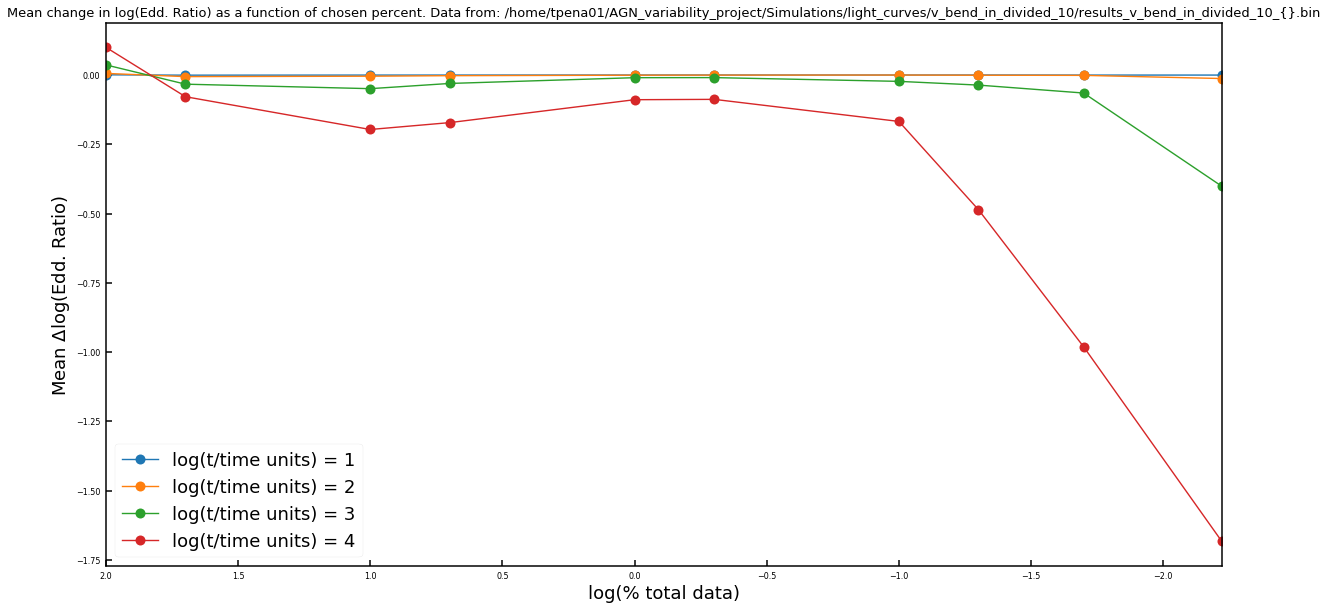

In [19]:
# PSD regime determination plot
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, figsize=(20, 10))
    
    ax.set_title('Mean change in log(Edd. Ratio) as a function of chosen percent. Data from: '+ data_path, fontsize=13)
    ax.tick_params(direction='in', length=6, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.set_xlabel('log(% total data)', fontsize=18)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('Mean $\Delta$log(Edd. Ratio)', fontsize=18)
    
    ax.plot(x, log_t_1, label='log(t/time units) = 1', marker='o', markersize=10)
    ax.plot(x, log_t_2, label='log(t/time units) = 2', marker='o', markersize=10)
    ax.plot(x, log_t_3, label='log(t/time units) = 3', marker='o', markersize=10)
    ax.plot(x, log_t_4, label='log(t/time units) = 4', marker='o', markersize=10)
    
    ax.legend(prop={'size':18})
    
plt.savefig('4-line_eddington_plot.pdf', bbox_inches='tight')  
plt.show()

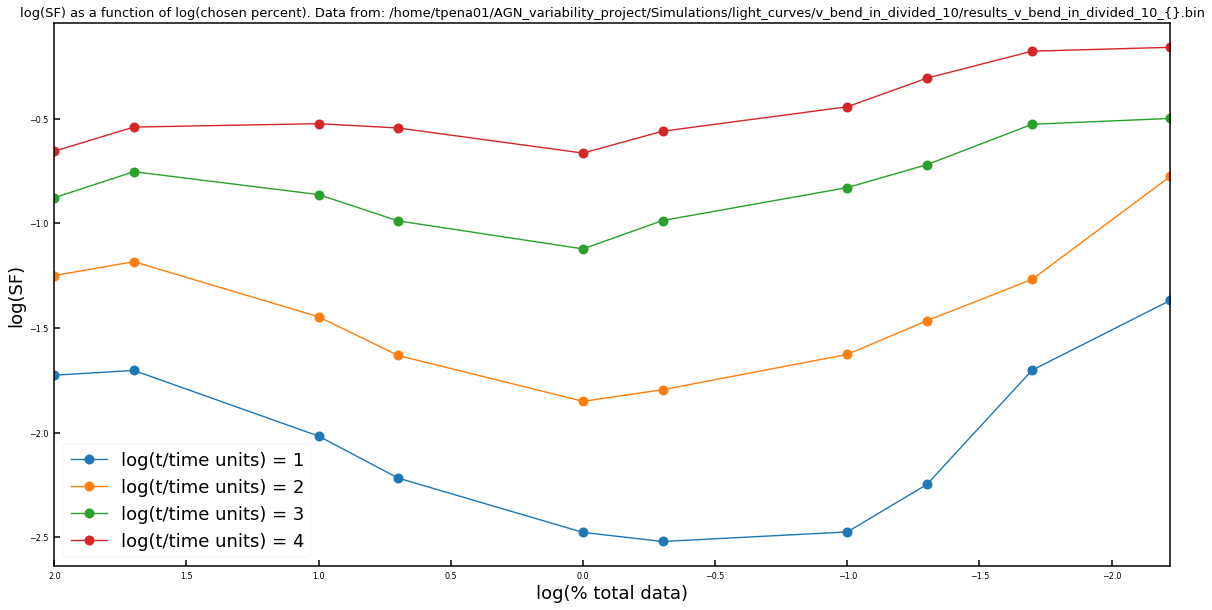

In [21]:
# Structure functions in a strange space
with plt.style.context('seaborn-paper'):
    fig, ax = plt.subplots(1, figsize=(20, 10))
    
    ax.set_title('log(SF) as a function of log(chosen percent). Data from: ' + data_path, fontsize=13)
    ax.tick_params(direction='in', length=6, width=1.5)
    ax.spines['top'].set_linewidth(1.5)
    ax.spines['right'].set_linewidth(1.5)
    ax.spines['bottom'].set_linewidth(1.5)
    ax.spines['left'].set_linewidth(1.5)
    ax.set_xlabel('log(% total data)', fontsize=18)
    ax.set_xlim(x[0], x[-1])
    ax.set_ylabel('log(SF)', fontsize=18)
    
    ax.plot(x, log_t_1_stands, label='log(t/time units) = 1', marker='o', markersize=10)
    ax.plot(x, log_t_2_stands, label='log(t/time units) = 2', marker='o', markersize=10)
    ax.plot(x, log_t_3_stands, label='log(t/time units) = 3', marker='o', markersize=10)
    ax.plot(x, log_t_4_stands, label='log(t/time units) = 4', marker='o', markersize=10)
    
    ax.legend(prop={'size':18})
    
plt.savefig('4-line_SF_plot.pdf', bbox_inches='tight')  
plt.show()